In [1]:
import json
import pprint
from pathlib import Path
import sys
sys.path.insert(1, '../src/utils')
import ipdb
import itertools
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from gensim.utils import simple_preprocess
from gensim import corpora, models
from gensim.models import Word2Vec
from gensim.models import CoherenceModel
from sklearn.manifold import TSNE
from sklearn.cluster import SpectralClustering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
from scipy.spatial.distance import cdist

from data import preprocessing

# Variables


In [2]:
num_topics = 5
use_title = True
# don't use stemming
stemming = False
lemmatization = True
# use nltk since it is a lot faster than spacy and the results are better with nltk
lib = "nltk"

input_path = Path("../src/data/data_jmlr_vol13-21.json")

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Data loading and preparation

## load

In [3]:
def load_data():
    with open(input_path, encoding="utf-8") as f:
        data = json.load(f)
    data_df = pd.json_normalize(data['papers'])
    corpus = data_df["abstract"]
    if use_title:
        corpus = data_df["title"] + " " + corpus 
    return corpus
corpus = load_data()


c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## preprocess
TODO: save after preprocessing so that there is no need to wait for a long time

In [4]:
corpus = preprocessing(
    corpus,
    lib=lib,
    stemming=stemming,
    lemmatization=lemmatization,
    min_word_len=2,
    max_word_len=15
)

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jessi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jessi\AppData\Roaming\nltk_data...


Dropping 0 entries of corpus, due to nan ...


[nltk_data]   Package punkt is already up-to-date!
12it [00:00, 114.28it/s]

Starting tokenization ...


1261it [00:06, 187.78it/s]


### tfidf

In [5]:
def identity_tokenizer(text):
    return text

def get_tfidf_corpus(corpus):
    vectorizer = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False)  
    return vectorizer, vectorizer.fit_transform(corpus["token"])
vectorizer, tfidf_corpus = get_tfidf_corpus(corpus)

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Clustering

In [8]:
def fit_model(model, corpus):
    model.fit(corpus)

def print_and_get_clusters(model, vectorizer, n_components=None, svd=None):
    print("Top terms per cluster:")
    if n_components:
        original_space_centroids = svd.inverse_transform(model.cluster_centers_)
        order_centroids = original_space_centroids.argsort()[:, ::-1]
    else:
        order_centroids = model.cluster_centers_.argsort()[:, ::-1]
    terms = vectorizer.get_feature_names()
    clusters = []
    for i in range(num_topics):
        print("Cluster %d:" % i),
        cluster = []
        for ind in order_centroids[i, :10]:
            print(' %s' % terms[ind])
            cluster.append(terms[ind])
        clusters.append(cluster)
        print("\n")
    return clusters
    
model = SpectralClustering(n_clusters=num_topics)
fit_model(model, tfidf_corpus)
clusters = print_and_get_clusters(model, vectorizer)


c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Top terms per cluster:
Cluster 0:
 policy
 gradient
 algorithm
 optimization
 stochastic
 method
 problem
 function
 convex
 convergence


Cluster 1:
 graph
 network
 algorithm
 clustering
 data
 problem
 model
 cluster
 set
 time


Cluster 2:
 learning
 feature
 data
 model
 machine
 algorithm
 label
 task
 library
 python


Cluster 3:
 matrix
 rank
 low
 covariance
 completion
 method
 sparse
 norm
 data
 factorization


Cluster 4:
 model
 regression
 data
 kernel
 method
 estimator
 distribution
 algorithm
 variable
 inference




Since the words which define the clusters look weird I use the sklearn preprocessing in the following. Our preprocessing should be improved. Or we decide to just use the sklearn preprocessing. But as far as I know they don't use lemmatization and stemming (TODO: true?)
With no stemming, the use of nltk and lowering the words, the result seems to be better. Therfore we use our own preprocessing again.

In [9]:
model_skelarn_preprocessed = KMeans(n_clusters=num_topics, init='k-means++', max_iter=100, n_init=1)
fit_model(model_skelarn_preprocessed, tfidf_corpus_sklearn_preprocessed)
clusters_sklearn_preprocessed = print_and_get_clusters(model_skelarn_preprocessed, vectorizer_sklearn)


c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Top terms per cluster:
Cluster 0:
 regression
 high
 dimensional
 data
 lasso
 model
 estimator
 estimation
 selection
 linear


Cluster 1:
 models
 learning
 model
 data
 inference
 networks
 causal
 latent
 network
 algorithms


Cluster 2:
 kernel
 learning
 data
 feature
 based
 kernels
 function
 problem
 density
 class


Cluster 3:
 optimization
 learning
 stochastic
 algorithms
 algorithm
 convex
 gradient
 convergence
 policy
 problems


Cluster 4:
 matrix
 clustering
 rank
 low
 completion
 algorithm
 sparse
 data
 subspace
 matrices




lemmatization would be good, because the defining words are redundant(e.g. models and model, graphs and graph, ...)

# Visualization

TODO: merge somehow with visualization of gensim_inspections? would be very difficult because of different inputs


c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


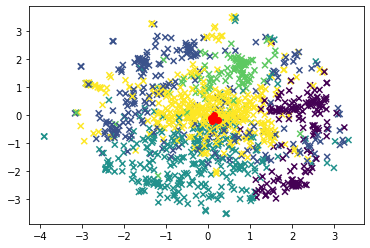

In [10]:
def plot(model, corpus, n_components=None):
    random_state = 1
    centroids = model.cluster_centers_

    tsne_init = 'pca'  # could also be 'random'
    tsne_perplexity = 20.0
    tsne_early_exaggeration = 4.0
    tsne_learning_rate = 10
    tsne = TSNE(n_components=2, random_state=random_state, init=tsne_init,
        perplexity=tsne_perplexity,
        early_exaggeration=tsne_early_exaggeration, learning_rate=tsne_learning_rate)
    if n_components:
        transformed = tsne.fit_transform(np.concatenate((corpus, centroids)))
    else:
        transformed = tsne.fit_transform(np.concatenate((corpus.todense(), centroids)))
    plt.scatter(transformed[:-num_topics, 0], transformed[:-num_topics, 1], c=model.labels_, marker='x')
    plt.scatter(transformed[-num_topics:, 0], transformed[-num_topics:, 1], c="red", marker='o')

    plt.show()
plot(model, tfidf_corpus)

# LSA and kmeans

In [11]:
def get_lsa_transformation(n_components, corpus):
    svd = TruncatedSVD(n_components)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)
    return lsa.fit_transform(corpus),svd

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
def find_n_components_and_k(corpus):
    for n_components in [2,3,4,5,6,7,8,9,10]:
        print("n_components: ", n_components)
        X, svd = get_lsa_transformation(n_components, corpus)
        find_k(X, 50)


c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


n_components:  2


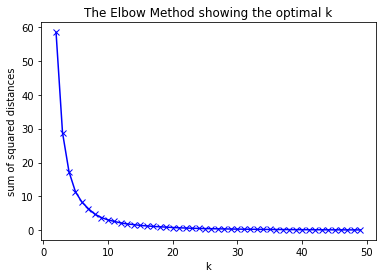

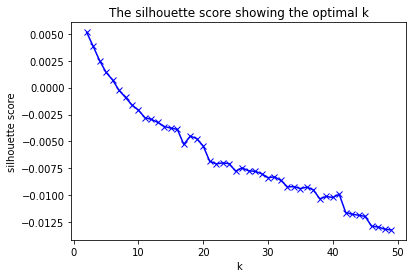

n_components:  3


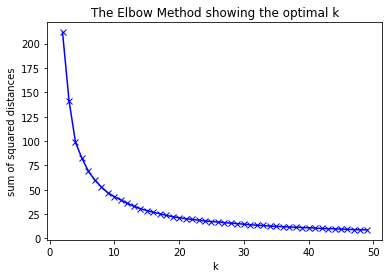

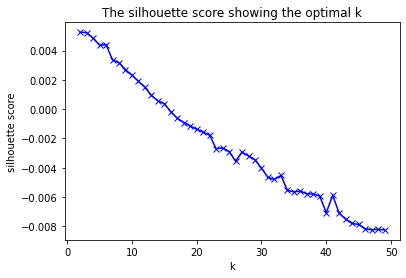

n_components:  4


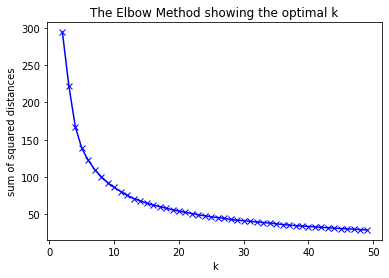

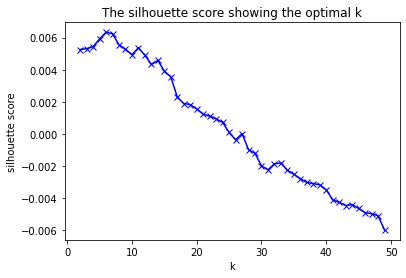

n_components:  5


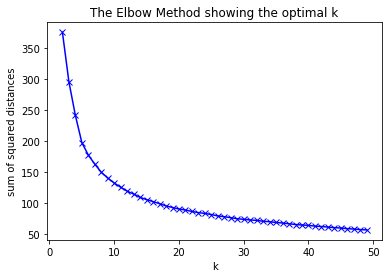

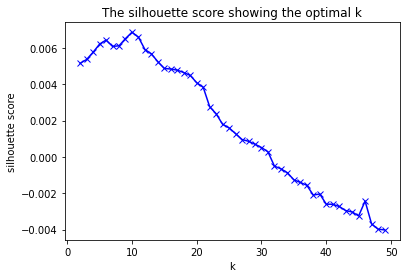

n_components:  6


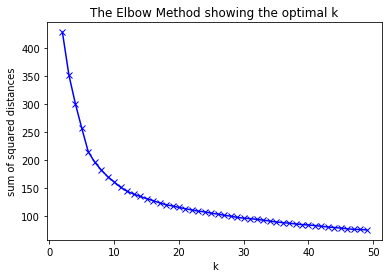

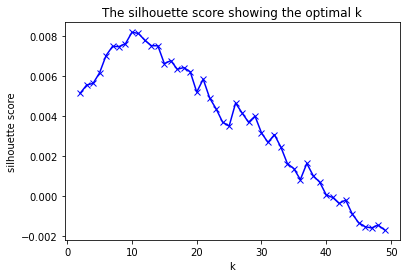

n_components:  7


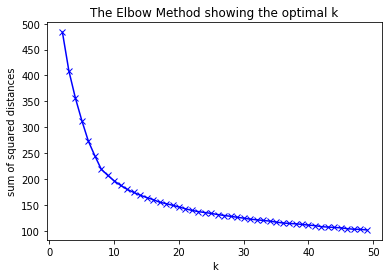

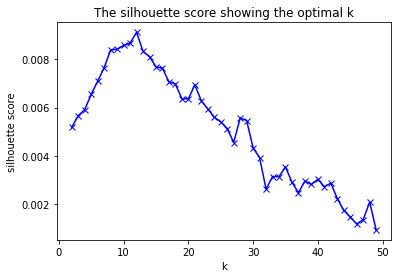

n_components:  8


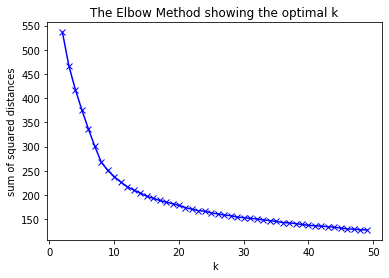

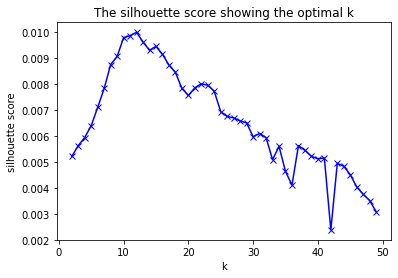

n_components:  9


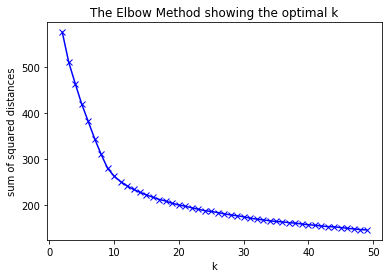

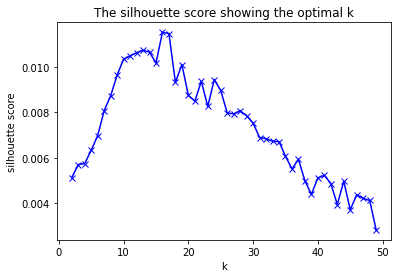

n_components:  10


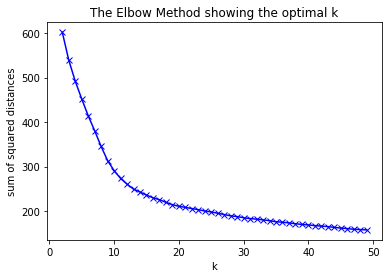

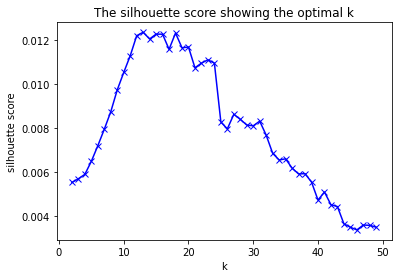

In [13]:
find_n_components_and_k(tfidf_corpus)


With LSA and kmeans a elbow is visible! The peak of the silhouette score moves to the right the higher n_component.
The optimal cluster number seems to be 15? With n_components = 10 also the peak of the silhouette score is at k=15. So maybe use num_topics= 15 and n_components=10?

The Silhouette Score is better without lsa (ca. 0,012 vs. ca. 0.014)

In [28]:
n_components = 10
X, svd = get_lsa_transformation(n_components, tfidf_corpus)
num_topics = 15
model_lsa = KMeans(n_clusters=num_topics, init='k-means++', max_iter=100, n_init=1)
fit_model(model_lsa, X)
clusters_with_lsa = print_and_get_clusters(model_lsa, vectorizer, n_components=n_components, svd=svd)


c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Top terms per cluster:
Cluster 0:
 data
 learning
 model
 algorithm
 method
 feature
 classification
 set
 regression
 approach


Cluster 1:
 learning
 algorithm
 policy
 data
 label
 problem
 classification
 task
 bound
 machine


Cluster 2:
 bound
 loss
 rate
 learning
 estimator
 sample
 class
 algorithm
 distribution
 error


Cluster 3:
 learning
 data
 machine
 feature
 library
 classification
 label
 task
 algorithm
 multi


Cluster 4:
 causal
 graph
 variable
 model
 effect
 learning
 data
 inference
 latent
 graphical


Cluster 5:
 matrix
 rank
 low
 completion
 bound
 tensor
 norm
 method
 sparse
 data


Cluster 6:
 network
 model
 neural
 node
 deep
 learning
 layer
 structure
 community
 time


Cluster 7:
 algorithm
 optimization
 convex
 gradient
 stochastic
 method
 problem
 function
 convergence
 learning


Cluster 8:
 model
 graph
 network
 graphical
 data
 gaussian
 inference
 variable
 method
 causal


Cluster 9:
 model
 inference
 data
 gaussian
 method
 bayesian
 pro

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


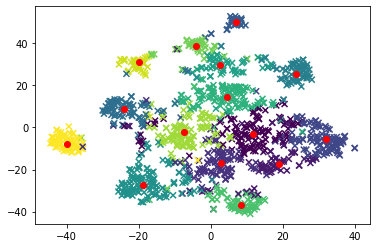

In [29]:
plot(model_lsa, X, n_components=n_components)

cluster centers look better than without lsa.

# Remove words which appear often in all clusters

In [18]:
terms = list(itertools.chain.from_iterable(clusters))
Counter(terms).most_common

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<bound method Counter.most_common of Counter({'algorithm': 4, 'data': 4, 'method': 3, 'model': 3, 'problem': 2, 'policy': 1, 'gradient': 1, 'optimization': 1, 'stochastic': 1, 'function': 1, 'convex': 1, 'convergence': 1, 'graph': 1, 'network': 1, 'clustering': 1, 'cluster': 1, 'set': 1, 'time': 1, 'learning': 1, 'feature': 1, 'machine': 1, 'label': 1, 'task': 1, 'library': 1, 'python': 1, 'matrix': 1, 'rank': 1, 'low': 1, 'covariance': 1, 'completion': 1, 'sparse': 1, 'norm': 1, 'factorization': 1, 'regression': 1, 'kernel': 1, 'estimator': 1, 'distribution': 1, 'variable': 1, 'inference': 1})>

In [30]:
terms = list(itertools.chain.from_iterable(clusters_with_lsa))
Counter(terms).most_common

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<bound method Counter.most_common of Counter({'data': 9, 'learning': 9, 'algorithm': 8, 'model': 6, 'method': 6, 'bound': 4, 'graph': 4, 'classification': 3, 'regression': 3, 'problem': 3, 'rate': 3, 'estimator': 3, 'causal': 3, 'variable': 3, 'inference': 3, 'graphical': 3, 'network': 3, 'function': 3, 'feature': 2, 'policy': 2, 'label': 2, 'task': 2, 'machine': 2, 'distribution': 2, 'latent': 2, 'node': 2, 'gaussian': 2, 'process': 2, 'clustering': 2, 'cluster': 2, 'kernel': 2, 'estimation': 2, 'density': 2, 'set': 1, 'approach': 1, 'loss': 1, 'sample': 1, 'class': 1, 'error': 1, 'library': 1, 'multi': 1, 'effect': 1, 'matrix': 1, 'rank': 1, 'low': 1, 'completion': 1, 'tensor': 1, 'norm': 1, 'sparse': 1, 'neural': 1, 'deep': 1, 'layer': 1, 'structure': 1, 'community': 1, 'time': 1, 'optimization': 1, 'convex': 1, 'gradient': 1, 'stochastic': 1, 'convergence': 1, 'bayesian': 1, 'variational': 1, 'reinforcement': 1, 'action': 1, 'regret': 1, 'high': 1, 'dimensional': 1, 'selection': 1,

Words that should be removed are algorithm, data, learning, method, model. This insight corresponds to the insight we get by printing the topwords of BoW and tfidf corpuses (milestone) 

In [20]:
custom_stopwords = ["algorithm", "data", "learning", "method", "model"]

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
corpus = load_data()

corpus_stopwords = preprocessing(
    corpus,
    lib=lib,
    stemming=stemming,
    lemmatization=lemmatization,
    min_word_len=2,
    max_word_len=15,
    custom_stopwords = custom_stopwords
)

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jessi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jessi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
18it [00:00, 173.03it/s]

Dropping 0 entries of corpus, due to nan ...
Starting tokenization ...


1261it [00:06, 188.28it/s]


In [22]:
vectorizer_stopwords, tfidf_corpus_stopwords = get_tfidf_corpus(corpus_stopwords)

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [31]:
n_components = 10
X, svd = get_lsa_transformation(n_components, tfidf_corpus_stopwords)
num_topics = 15
model_stopwords = KMeans(n_clusters=num_topics, init='k-means++', max_iter=100, n_init=1)
fit_model(model_stopwords, X)
clusters_with_lsa_stopwords = print_and_get_clusters(model_stopwords, vectorizer_stopwords, n_components=n_components, svd=svd)

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Top terms per cluster:
Cluster 0:
 regression
 estimator
 rate
 variable
 kernel
 high
 selection
 lasso
 dimensional
 estimation


Cluster 1:
 graph
 clustering
 cluster
 matrix
 problem
 label
 density
 bound
 based
 spectral


Cluster 2:
 matrix
 rank
 regression
 problem
 sparse
 estimator
 approach
 variable
 low
 estimation


Cluster 3:
 graph
 network
 graphical
 causal
 variable
 gaussian
 inference
 node
 structure
 estimation


Cluster 4:
 network
 neural
 node
 deep
 structure
 community
 layer
 time
 training
 graph


Cluster 5:
 inference
 bayesian
 gaussian
 process
 variational
 distribution
 latent
 posterior
 prior
 approximation


Cluster 6:
 kernel
 regression
 function
 space
 estimator
 density
 rate
 mean
 hilbert
 approximation


Cluster 7:
 feature
 machine
 library
 classification
 python
 multi
 task
 source
 set
 framework


Cluster 8:
 bound
 loss
 label
 class
 rate
 distribution
 sample
 estimator
 classification
 risk


Cluster 9:
 optimization
 convex
 g

In [32]:
terms = list(itertools.chain.from_iterable(clusters_with_lsa_stopwords))
Counter(terms).most_common

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<bound method Counter.most_common of Counter({'problem': 6, 'graph': 5, 'regression': 4, 'estimator': 4, 'variable': 4, 'bound': 4, 'rate': 3, 'estimation': 3, 'matrix': 3, 'label': 3, 'network': 3, 'graphical': 3, 'causal': 3, 'node': 3, 'approximation': 3, 'function': 3, 'classification': 3, 'kernel': 2, 'selection': 2, 'lasso': 2, 'dimensional': 2, 'clustering': 2, 'cluster': 2, 'density': 2, 'based': 2, 'spectral': 2, 'rank': 2, 'sparse': 2, 'low': 2, 'gaussian': 2, 'inference': 2, 'structure': 2, 'distribution': 2, 'space': 2, 'feature': 2, 'machine': 2, 'multi': 2, 'task': 2, 'set': 2, 'class': 2, 'policy': 2, 'high': 1, 'approach': 1, 'neural': 1, 'deep': 1, 'community': 1, 'layer': 1, 'time': 1, 'training': 1, 'bayesian': 1, 'process': 1, 'variational': 1, 'latent': 1, 'posterior': 1, 'prior': 1, 'mean': 1, 'hilbert': 1, 'library': 1, 'python': 1, 'source': 1, 'framework': 1, 'loss': 1, 'sample': 1, 'risk': 1, 'optimization': 1, 'convex': 1, 'gradient': 1, 'stochastic': 1, 'con

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


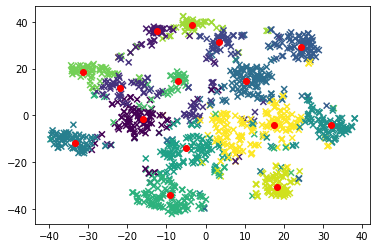

In [33]:
plot(model_stopwords, X, n_components=n_components)

The clusters look now not as good as before in my opinion. Maybe we need new k and n_components?

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


n_components:  2


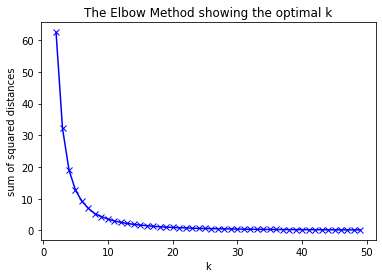

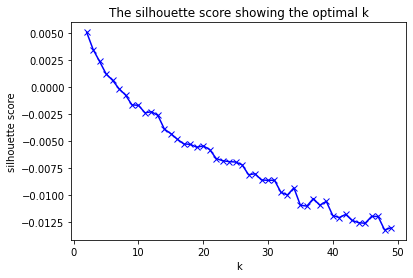

n_components:  3


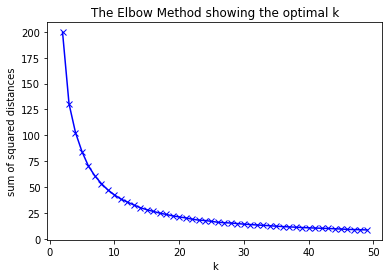

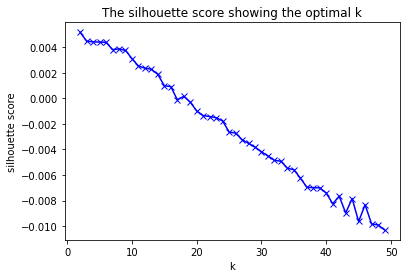

n_components:  4


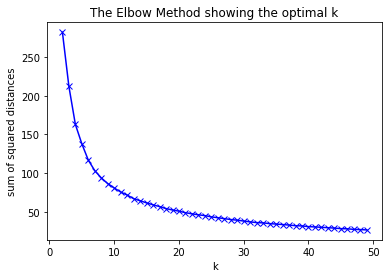

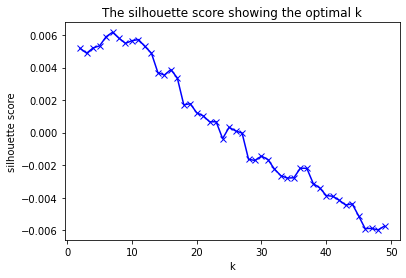

n_components:  5


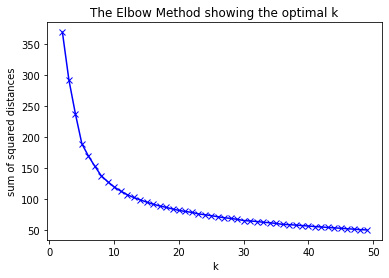

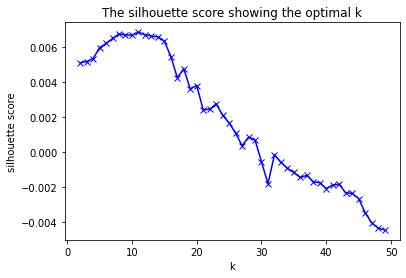

n_components:  6


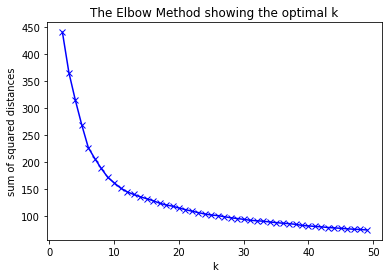

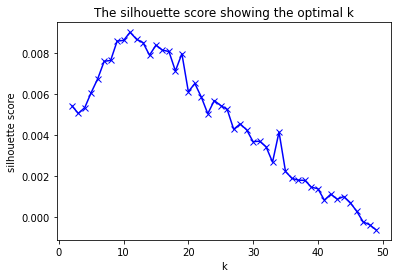

n_components:  7


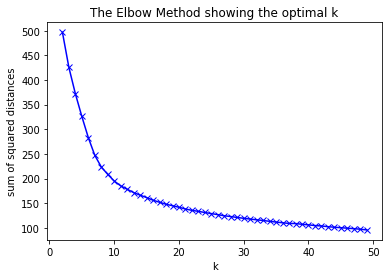

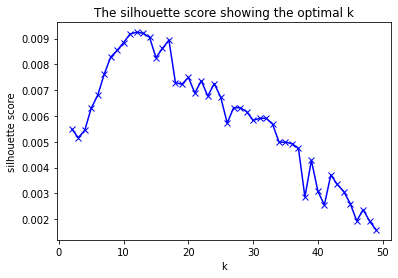

n_components:  8


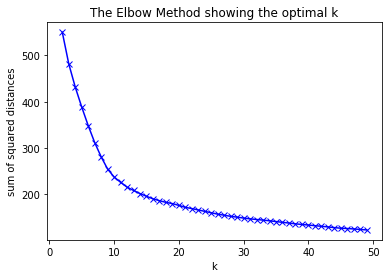

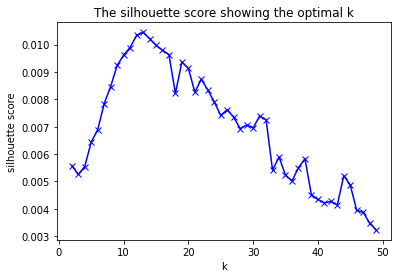

n_components:  9


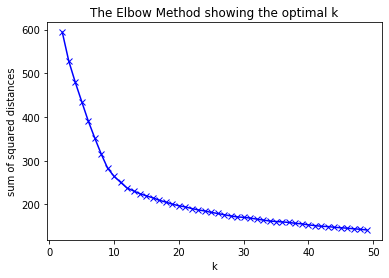

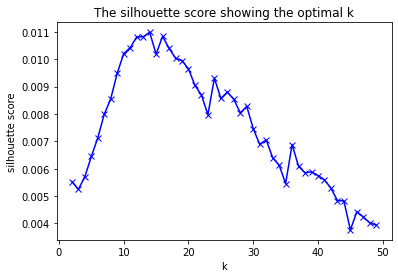

n_components:  10


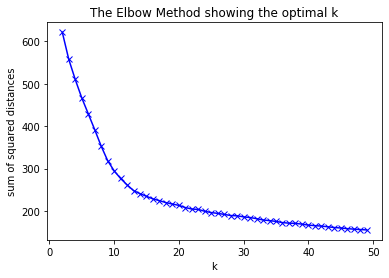

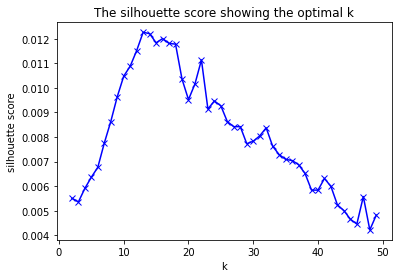

In [27]:
find_n_components_and_k(tfidf_corpus_stopwords)

Looks similar to before.